In [1]:
import numpy as np
import pandas as pd
from scipy.io import netcdf
from scipy import signal
from datetime import datetime
import matplotlib.pyplot as plt
import random as rand
from wavesim1d import *



%load_ext autoreload
%autoreload 2

In [2]:
#Load a sample avg spectra

#fname = "/Volumes/TFO-exFAT-1/TFO/LCDRI/CDIPwaverider229/229p1_d01.nc";
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"
[times, f, spectra] = load_CDIP(fname)
test_spectra = np.mean(spectra[150:160, :], 0)
#f2 = np.linspace(f[0], f[-1], num=256)
#spec2 = np.interp(f2, f, test_spectra)
#f = f2
#test_spectra = spec2

In [3]:

#Now make a 2-d  velocity grid field from a spectrum
#Assume random phase, and random direction

x_range = np.arange(0, 10, 1)
z_range = np.arange(0, 1, 1)
t_range_surf = np.arange(0, 1200, 1)
#xx, zz = np.meshgrid(x_range, z_range)
tt, zzt = np.meshgrid(t_range_surf, z_range)

#tt, xx, zz = np.meshgrid(x_range, z_range, t_range)
#y_range = [0, 100]

#Normally would loop through at each time step and generate a x-z wave field
#Lets start with t=0
n_iter = 500

fs = 1
u_store_surf = np.zeros((n_iter, len(t_range_surf)));

#Number of iterations to run
zeta_store = np.zeros((n_iter, len(t_range_surf)))
df = f[2]-f[1]
t = 0
x = 0
for jj in range(0, n_iter-1):
    for i in range(0, len(f)-1):
        freq = f[i]
        if i == 0:
            df = f[1]-f[0]
        elif i == len(f)-1:
            df = f[i]-f[i-1]
        else:
            i
            df = (f[i+1]-f[i-1])/2
            
        omega = 2*np.pi*freq;
        k = np.square(omega)/9.8     
        a = np.sqrt(test_spectra[i]*df*2) 

        #Randomize phase
        phi = rand.random()*2*np.pi;
        
        #Randomize direction?
        #TO DO: Need to have peak in narrow directional band
        #Should we be able to input directional spectra
        
        u = a*omega*np.cos(k*x-omega*tt + phi)*np.exp(-k*zzt)
        zeta = a*np.cos(k*x-omega*t_range_surf + phi)
        #print(u)
        u_store_surf[jj, :] = u_store_surf[jj, :] + u
        zeta_store[jj, :] = zeta_store[jj, :] + zeta
#how do we choose the amplitude for each frequency?


##Add white noise to the surface measurements

mean = 0
std = 0.01 
num_samples = len(u_store_surf[:, 0])*len(u_store_surf[0, :])
rand_samples = 0.008*np.random.normal(loc = 0, scale = 1, size = num_samples)
rand_samples = rand_samples.reshape((len(u_store_surf[:, 0]), len(u_store_surf[0, :])))
u_noise_surf = u_store_surf + rand_samples

#Now we take the spectra

nblock = 120
overlap = int(nblock/2)
fs = 1
Cmax = 25
w = nblock


#Em-APEX Sampling Grid
t_range = np.arange(0, 1000)
t_range, em_x, em_z = apex_sampling_grid(t_range)

#build the u-time-series
[u_store, u_noise, u_surf] = build_u_timeseries(t_range, em_z, em_x, test_spectra, f)

#highpass filter
sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
u_noise = signal.sosfilt(sos, u_noise, axis=-1)
u_noise_surf = signal.sosfilt(sos, u_noise_surf, axis=-1)

#Reshape the u time series
[u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)
[u_new_noise, z_new] = reshape_u(u_noise, em_z, nblock, overlap, fs)


#Make the actual spectra by calling the function above
UUwindow, fwindow= make_vel_spectrum(u_new, fs)
UUwindow_noise, fwindow = make_vel_spectrum(u_new_noise, fs)


#Compute the raw Energy Density Spectra
UU = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
#UU_noise = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
#Exx_noise = UU_noise[1:]/ (np.square((2*np.pi*fwindow[1:])))


#Apply Eric's Correction
[UUwindow_Eric1, UUwindow_Eric2, UUwindow_Eric3, UUwindow_Eric4] = depth_correct_Eric(UUwindow_noise, fwindow, z_new, w, Cmax, fs)
#Compute the raw Energy Density Spectra
UU_Eric1 = np.nanmean(np.nanmean(UUwindow_Eric1, axis=0), axis=0)/(int(w/2)*fs)
Exx_Eric1 = UU_Eric1[1:]/ (np.square((2*np.pi*fwindow[1:])))

UU_Eric2 = np.nanmean(np.nanmean(UUwindow_Eric2, axis=0), axis=0)/(int(w/2)*fs)
Exx_Eric2 = UU_Eric2[1:]/ (np.square((2*np.pi*fwindow[1:])))

UU_Eric3 = np.nanmean(np.nanmean(UUwindow_Eric3, axis=0), axis=0)/(int(w/2)*fs)
Exx_Eric3 = UU_Eric3[1:]/ (np.square((2*np.pi*fwindow[1:])))

UU_Eric4 = np.nanmean(np.nanmean(UUwindow_Eric4, axis=0), axis=0)/(int(w/2)*fs)
Exx_Eric4 = UU_Eric4[1:]/ (np.square((2*np.pi*fwindow[1:])))


eric4_std = np.nanstd(np.nanmean(UUwindow_Eric4, axis=1), axis=0)/(int(w/2)*fs)
eric_err_t = (UU_Eric4+eric4_std)[1:]/ (np.square((2*np.pi*fwindow[1:])))
eric_err_b = (UU_Eric4-eric4_std)[1:]/ (np.square((2*np.pi*fwindow[1:])))
#eric4_std = eric4_std[1:]/(np.square((2*np.pi*fwindow[1:])))

raw_std = np.nanstd(np.nanmean(UUwindow, axis=1), axis=0)/(int(w/2)*fs)
raw_err_t = (UU+raw_std)[1:]/ (np.square((2*np.pi*fwindow[1:])))
raw_err_b = (UU-raw_std)[1:]/ (np.square((2*np.pi*fwindow[1:])))
#raw_std = raw_std[1:]/(np.square((2*np.pi*fwindow[1:])))

/Users/jamesstadler/Documents/UW/TFO/Code/EMAPEX_WAVES/WaveSimulations/wavesim1d.py:307: RuntimeWarning: invalid value encountered in true_divide
  G = np.square( (np.square(np.pi)/(np.square(kWT/2)+np.square(np.pi)))*(np.sinh(kWT/2)/(kWT/2)) )
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_26335/1092575112.py:105: RuntimeWarning: Mean of empty slice
  UU_Eric1 = np.nanmean(np.nanmean(UUwindow_Eric1, axis=0), axis=0)/(int(w/2)*fs)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_26335/1092575112.py:108: RuntimeWarning: Mean of empty slice
  UU_Eric2 = np.nanmean(np.nanmean(UUwindow_Eric2, axis=0), axis=0)/(int(w/2)*fs)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_26335/1092575112.py:111: RuntimeWarning: Mean of empty slice
  UU_Eric3 = np.nanmean(np.nanmean(UUwindow_Eric3, axis=0), axis=0)/(int(w/2)*fs)
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_26335/1092575112.py:114: RuntimeWarning: Mean of empty slice
  UU_Eric4 = np.nanmean(np.na

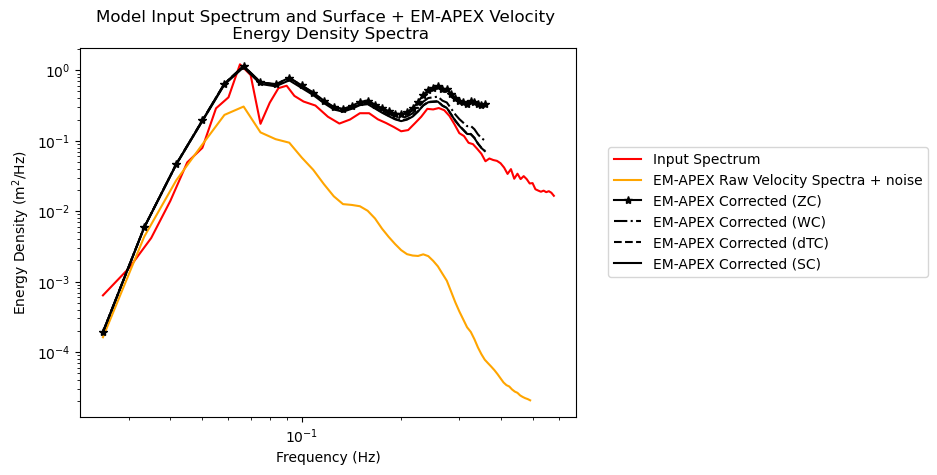

In [4]:
#Plot Spectra

nblock =120
overlap = 60
fs=1
w=120
[u_surf, z_new_surf] = reshape_u(u_noise_surf, t_range_surf, nblock, overlap, fs)

UUwindow_surf, fwindow_surf= make_vel_spectrum(u_surf, fs)
UU_surf = np.nanmean(UUwindow_surf, axis=0)/(int(w/2)*fs)
Exx_surf = np.nanmean(UU_surf[:, 1:], axis=0)/ (np.square((2*np.pi*fwindow_surf[1:])))



plt.loglog(f, test_spectra, 'r', label="Input Spectrum")
#plt.loglog(fwindow_surf[1:], Exx_surf, 'b', label="Surface Velocity + noise ")
plt.loglog(fwindow[3:], Exx[2:], color='orange', label = "EM-APEX Raw Velocity Spectra + noise")
plt.loglog(fwindow[3:], Exx_Eric1[2:], '-*k', label = "EM-APEX Corrected (ZC)")
plt.loglog(fwindow[3:], Exx_Eric2[2:], '-.k', label = "EM-APEX Corrected (WC)")
plt.loglog(fwindow[3:], Exx_Eric3[2:], '--k', label = "EM-APEX Corrected (dTC)")
plt.loglog(fwindow[3:], Exx_Eric4[2:], 'k', label = "EM-APEX Corrected (SC)")
#plt.loglog(fwindow[3:], Exx_Eric4[2:]+eric4_std[2:], color='c')
#plt.loglog(fwindow[3:], Exx_Eric4[2:]-eric4_std[2:], color='c')
#plt.fill_between(fwindow[3:], Exx_Eric4[2:]-eric4_std[2:], Exx_Eric4[2:]+eric4_std[2:], alpha=0.5, edgecolor='c', facecolor='c')
#plt.fill_between(fwindow[3:], eric_err_b[2:], eric_err_b[2:], alpha=0.5, edgecolor='c', facecolor='c')
#plt.fill_between(fwindow[3:], raw_err_b[2:], raw_err_t[2:], alpha=0.5, edgecolor='c', facecolor='c')




#Get min/max integration bounds for swh calculation
lbound = f[0];
ubound = fwindow[-1]
#plt.fill_between(fwindow[3:], 0, Exx_Eric1[2:], where=(fwindow[3:] <= ubound) & (fwindow[3:] >= lbound-.01), alpha=0.5)

#plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.05, 0.75))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Energy Density (m$^2$/Hz)")
plt.title("Model Input Spectrum and Surface + EM-APEX Velocity \n Energy Density Spectra")
save_folder="/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/WaveSimulations/"


#plt.savefig(save_folder+"Corrections.png", bbox_inches='tight')

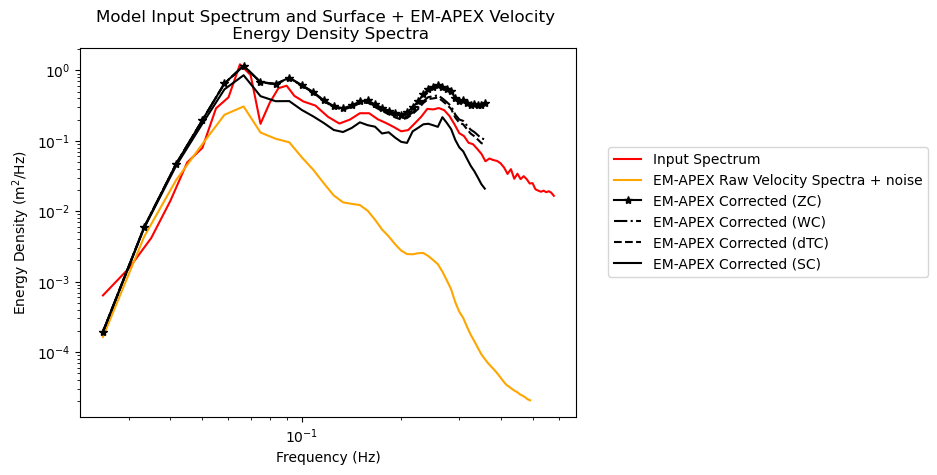

In [10]:
#Plot Spectra

nblock =120
overlap = 60
fs=1
w=120
[u_surf, z_new_surf] = reshape_u(u_noise_surf, t_range_surf, nblock, overlap, fs)

UUwindow_surf, fwindow_surf= make_vel_spectrum(u_surf, fs)
UU_surf = np.nanmean(UUwindow_surf, axis=0)/(int(w/2)*fs)
Exx_surf = np.nanmean(UU_surf[:, 1:], axis=0)/ (np.square((2*np.pi*fwindow_surf[1:])))



plt.loglog(f, test_spectra, 'r', label="Input Spectrum")
#plt.loglog(fwindow_surf[1:], Exx_surf, 'b', label="Surface Velocity + noise ")
plt.loglog(fwindow[3:], Exx[2:], color='orange', label = "EM-APEX Raw Velocity Spectra + noise")
plt.loglog(fwindow[3:], Exx_Eric1[2:], '-*k', label = "EM-APEX Corrected (ZC)")
plt.loglog(fwindow[3:], Exx_Eric2[2:], '-.k', label = "EM-APEX Corrected (WC)")
plt.loglog(fwindow[3:], Exx_Eric3[2:], '--k', label = "EM-APEX Corrected (dTC)")
plt.loglog(fwindow[3:], Exx_Eric4[2:], 'k', label = "EM-APEX Corrected (SC)")
#plt.loglog(fwindow[3:], Exx_Eric4[2:]+eric4_std[2:], color='c')
#plt.loglog(fwindow[3:], Exx_Eric4[2:]-eric4_std[2:], color='c')
#plt.fill_between(fwindow[3:], Exx_Eric4[2:]-eric4_std[2:], Exx_Eric4[2:]+eric4_std[2:], alpha=0.5, edgecolor='c', facecolor='c')
#plt.fill_between(fwindow[3:], eric_err_b[2:], eric_err_b[2:], alpha=0.5, edgecolor='c', facecolor='c')
#plt.fill_between(fwindow[3:], raw_err_b[2:], raw_err_t[2:], alpha=0.5, edgecolor='c', facecolor='c')




#Get min/max integration bounds for swh calculation
lbound = f[0];
ubound = fwindow[-1]
#plt.fill_between(fwindow[3:], 0, Exx_Eric1[2:], where=(fwindow[3:] <= ubound) & (fwindow[3:] >= lbound-.01), alpha=0.5)

#plt.legend(loc='lower left')
plt.legend(bbox_to_anchor=(1.05, 0.75))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Energy Density (m$^2$/Hz)")
plt.title("Model Input Spectrum and Surface + EM-APEX Velocity \n Energy Density Spectra")
save_folder="/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/WaveSimulations/"


#plt.savefig(save_folder+"Corrections.png", bbox_inches='tight')

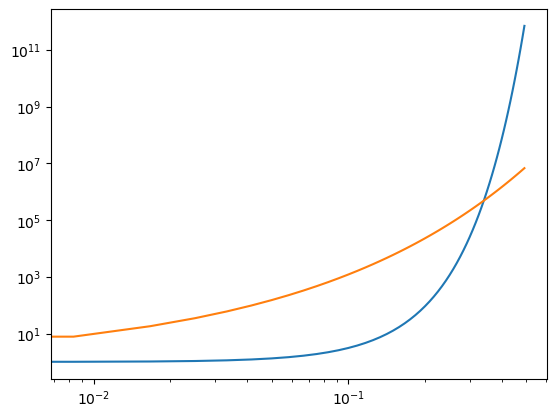

In [27]:
omega = 2*np.pi*fwindow
k = np.square(omega)/9.8
kfake = np.sqrt(omega/9.8)
z = 14
plt.loglog(fwindow, np.exp(2*k*z))
plt.loglog(fwindow, np.exp(2*kfake*z))


In [40]:
np.exp(k[10]*2*30)

5.357535903296903

In [36]:
1/fwindow[10]

12.0

array([           nan, 6.93889390e-18, 1.01770444e-17, 1.15648232e-17,
       1.85037171e-18, 1.01770444e-17, 1.85037171e-18, 2.96059473e-17,
       1.96139401e-16, 4.81096644e-17, 1.11022302e-16, 5.47710025e-16,
       6.51330841e-16, 3.10862447e-16, 2.36847579e-16, 1.00660221e-15,
       1.65793305e-15, 7.57912251e-15, 1.18423789e-16, 6.75015599e-15,
       8.17124146e-15, 7.34227494e-15, 3.90798505e-15, 5.32907052e-15,
       1.42108547e-15, 3.07901852e-15, 1.89478063e-15, 1.00660221e-14,
       6.63173220e-15, 1.19608027e-14, 5.68434189e-15, 1.39740071e-14,
       9.47390314e-16, 1.18423789e-15, 1.68161781e-14, 2.84217094e-15,
       2.27373675e-14, 1.94215014e-14, 2.84217094e-15, 4.50010399e-15,
       6.86857978e-15, 4.97379915e-15, 1.04212935e-14, 8.05281767e-15,
       5.92118946e-15, 1.11318362e-14, 1.23160741e-14, 1.87109587e-14,
       1.13686838e-14, 5.68434189e-15, 9.94759830e-15, 3.78956126e-15,
       1.89478063e-15, 9.94759830e-15, 1.61056353e-14, 8.52651283e-15,
      

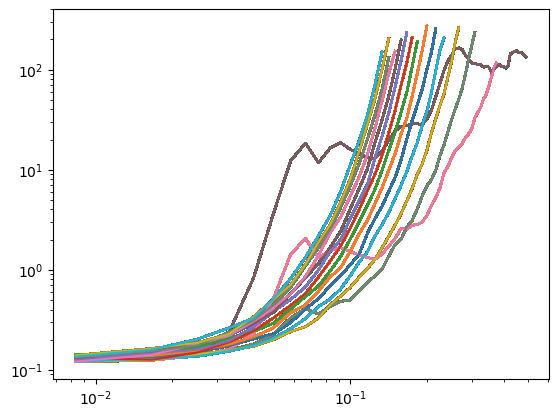

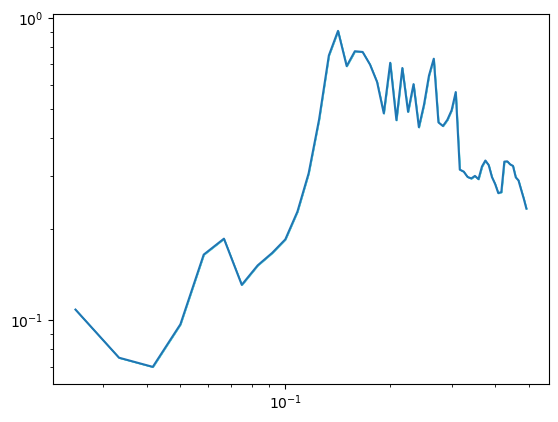

In [17]:
#blah =np.nanmean(UUwindow_Eric4, axis=1)
plt.loglog(fwindow,np.transpose(np.reshape(UUwindow_Eric4, (7500,60))))
eric_std = np.nanstd(np.reshape(UUwindow_noise, (7500,60)), axis=0)
eric_err_t = (UU_Eric4+eric4_std)[1:]/ (np.square((2*np.pi*fwindow[1:])))
eric_err_b = (UU_Eric4-eric4_std)[1:]/ (np.square((2*np.pi*fwindow[1:])))
plt.figure()
plt.loglog(fwindow[3:], Exx_Eric4[2:])
plt.fill_between(fwindow[3:], eric_err_b[2:], eric_err_b[2:], alpha=0.5, edgecolor='c', facecolor='c')
eric4_std

In [110]:
Exx_Eric4

array([1.38026192e-04, 4.30499139e-04, 1.19890560e-02, 1.47697563e-01,
       3.92431427e-01, 8.14860607e-01, 1.61025086e+00, 2.08070535e+00,
       9.21836703e-01, 1.04059854e+00, 1.07671353e+00, 8.41179525e-01,
       6.92116873e-01, 5.80501477e-01, 4.78078402e-01, 5.07765721e-01,
       5.66040925e-01, 6.38981125e-01, 6.26538831e-01, 5.56005427e-01,
       4.99351258e-01, 4.84689203e-01, 4.26084717e-01, 4.10364377e-01,
       4.45785795e-01, 5.12297777e-01, 6.40784991e-01, 7.94453520e-01,
       8.37112376e-01, 8.84805358e-01, 8.73990693e-01, 7.75471831e-01,
       6.33992311e-01, 5.08962130e-01, 4.19842840e-01, 3.27735846e-01,
       2.80963273e-01, 2.39101059e-01, 2.18647650e-01, 1.90471634e-01,
       1.59865367e-01, 1.29233927e-01, 1.10461635e-01, 1.08595232e-01,
       1.00784194e-01, 8.55330006e-02, 7.22899294e-02, 6.20332178e-02,
       5.26365689e-02, 4.81244210e-02, 5.29417050e-02, 5.13909893e-02,
       4.83502667e-02, 4.10855567e-02, 3.51368695e-02, 3.32866695e-02,
      

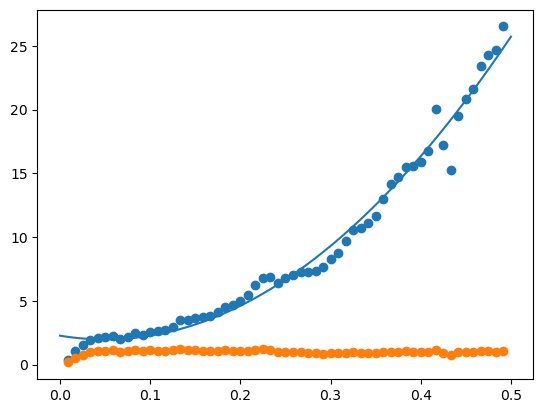

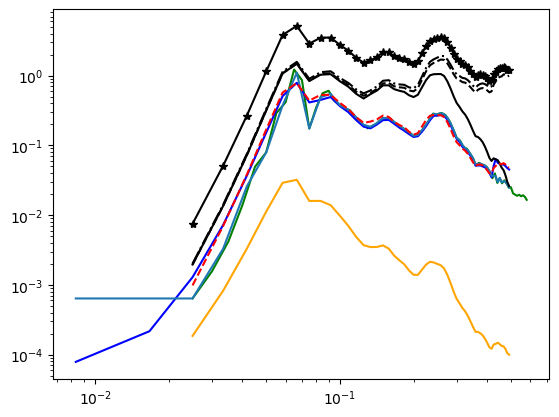

In [58]:
##Plot the WC/surface

spec2 = np.interp(fwindow[1:], f, test_spectra)
Gain = Exx_Eric2/Exx_surf


plt.figure()
plt.scatter(fwindow[1:], Gain)

fit = np.polyfit(fwindow[1:], Gain, 2)
p = np.poly1d(fit)
xp = np.linspace(0, 0.5, 100)
plt.plot(xp, p(xp))

minus = Gain/p(fwindow[1:])
fixed = Exx_Eric2/p(fwindow[1:])
plt.plot(fwindow[1:], minus, 'o')

plt.figure()
plt.loglog(f, test_spectra, 'g', label="Input Spectrum")
plt.loglog(fwindow_surf[1:], Exx_surf, 'b', label="Surface Velocity + noise ")
plt.loglog(fwindow_surf[1:], spec2)
plt.loglog(fwindow[3:], Exx[2:], color='orange', label = "EM-APEX Raw Velocity Spectra + noise")
plt.loglog(fwindow[3:], Exx_Eric1[2:], '-*k', label = "EM-APEX Corrected (ZC)")
plt.loglog(fwindow[3:], Exx_Eric2[2:], '-.k', label = "EM-APEX Corrected (WC)")
plt.loglog(fwindow[3:], Exx_Eric3[2:], '--k', label = "EM-APEX Corrected (dTC)")
plt.loglog(fwindow[3:], Exx_Eric4[2:], 'k', label = "EM-APEX Corrected (SC)")
plt.loglog(fwindow[3:], fixed[2:], '--r')

In [33]:
## Calculate error for each correction (in terms of SWH)
swh_base = sig_wave_height(f, test_spectra)
swh_raw= sig_wave_height(fwindow[3:], Exx[2:])
swh_1 = sig_wave_height(fwindow[3:], Exx_Eric1[2:])
swh_2 = sig_wave_height(fwindow[3:], Exx_Eric2[2:])
swh_3 = sig_wave_height(fwindow[3:], Exx_Eric3[2:])
swh_4 = sig_wave_height(fwindow[3:], Exx_Eric4[2:])
    
#Put the swh's in the dataframe
data = [swh_base, swh_raw, swh_1, swh_2, swh_3, swh_4]
error = np.abs(100*(data - swh_base))/swh_base
df2 = pd.DataFrame(data = [data, error], columns=['Input', 'Raw', 'ZC', 'WC', 'dTC', 'SC'])
df2

,Input,Raw,ZC,WC,dTC,SC
0,0.970909,0.127757,2.011130,1.227303,1.177392,1.064092
1,0.000000,86.841527,107.138923,26.407704,21.267070,9.597584


In [ ]:
#Calculate max% difference of full 

In [ ]:
#Plot surface timeseries and sample depth decay of signal

u_surf_tseries = u_noise_surf[2, :]
u_em_tseries = u_noise[2, :]
plt.plot(t_range_surf[0:300], u_surf_tseries[0:300])
plt.plot(t_range[0:300], u_em_tseries[0:300])
plt.title("Sample surface and EM-APEX velocity timeseries")
plt.xlabel("Time (s)")
plt.ylabel("u (m/s)")

In [ ]:
plt.plot(u_em_tseries[0:300], em_z[0:300])
plt.ylim([30, 0])
plt.xlabel("u(m/s)")
plt.ylabel("Depth (m)")
plt.title("Sample Em-APEX modelled velocity profile")
plt.savefig(save_folder+"Simulated_u_prof.png")


In [ ]:
nc = netcdf.NetCDFFile(fname, 'r', mmap=False)
Hs = nc.variables['waveHs'][:]
np.nanmean(Hs[100:110])

/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_51235/500845571.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(fwindow, np.nanmean(UUwindow_noise, axis=0)[window, :]/(60)/(np.square((2*np.pi*fwindow[:]))), label=str(depth)+"m")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_51235/500845571.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(fwindow, np.nanmean(UUwindow_noise, axis=0)[window, :]/(60)/(np.square((2*np.pi*fwindow[:]))), label=str(depth)+"m")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_51235/500845571.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(fwindow, np.nanmean(UUwindow_noise, axis=0)[window, :]/(60)/(np.square((2*np.pi*fwindow[:]))), label=str(depth)+"m")
/var/folders/77/7yfflvs902s95j6rlhb5yn9c0000gn/T/ipykernel_51235/500845571.py:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(fwindow, np.nanmean(UUwindow_noise, axis=

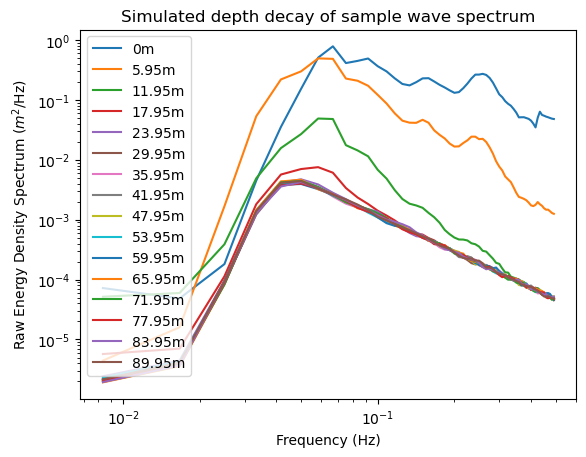

In [159]:

nwindows = UUwindow.shape[1]
plt.loglog(fwindow_surf[1:], Exx_surf, label="0m")
for window in range(nwindows):
    depth = np.nanmean(z_new[window, :])
    plt.loglog(fwindow, np.nanmean(UUwindow_noise, axis=0)[window, :]/(60)/(np.square((2*np.pi*fwindow[:]))), label=str(depth)+"m")
    


plt.legend()
plt.title("Simulated depth decay of sample wave spectrum")
plt.ylabel("Raw Energy Density Spectrum ($m^2$/Hz)")
plt.xlabel("Frequency (Hz)")

plt.savefig(save_folder+"Sample_Depth_Decay.png", bbox_inches='tight')

In [135]:
[u_new, z_new] = reshape_u(u_store, em_z, nblock, overlap, fs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169

In [138]:
z_new

array([[ 0. ,  0.1,  0.2, ..., 11.7, 11.8, 11.9],
       [ 6. ,  6.1,  6.2, ..., 17.7, 17.8, 17.9],
       [12. , 12.1, 12.2, ..., 23.7, 23.8, 23.9],
       ...,
       [72. , 72.1, 72.2, ..., 83.7, 83.8, 83.9],
       [78. , 78.1, 78.2, ..., 89.7, 89.8, 89.9],
       [84. , 84.1, 84.2, ..., 95.7, 95.8, 95.9]])

In [14]:
G = [np.NaN, 0.25635601, 0.26285732, 0.26950692, 0.27630787, 0.2832633,
 0.29037638, 0.29765034, 0.30508849, 0.31269417, 0.32047081, 0.3284219,
 0.33655098, 0.34486166, 0.35335764, 0.36204265, 0.37092052, 0.37999514,
 0.38927046, 0.39875053, 0.40843945, 0.41834141, 0.42846066, 0.43880154,
 0.44936848, 0.46016597, 0.47119858, 0.48247099, 0.49398794, 0.50575427,
 0.5177749,  0.53005483, 0.54259918, 0.55541313, 0.56850197, 0.58187108,
 0.59552594, 0.60947214, 0.62371534, 0.63826132, 0.65311598, 0.66828528,
 0.68377533, 0.69959234, 0.7157426,  0.73223255, 0.74906872, 0.76625776,
 0.78380646, 0.8017217,  0.82001048, 0.83867996, 0.85773738, 0.87719014,
 0.89704576, 0.91731188, 0.93799629, 0.95910691, 0.9806518,  1.00263916]

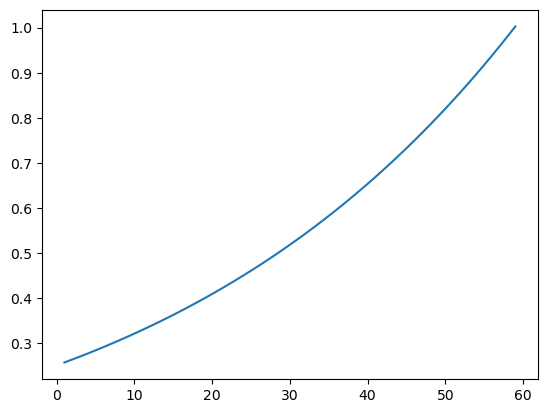

In [15]:
plt.plot(G)

In [ ]:
print("Hello")

In [29]:
[u_surf, z_surf] = reshape_u(u_store_surf, t_range_surf, nblock, overlap, fs)

In [30]:
np.max(u_surf)

7.783073154383542e+57

In [31]:
u_surf.shape

(500, 19, 120)

In [35]:
len(u_store_surf[1, :])/60-1

19.0

In [44]:
u_surf

array([[[ 0.01623915,  0.44333243,  0.4986736 , ..., -0.11280399,
         -0.54179816,  0.15138943],
        [ 0.12370269, -0.32299044,  0.13670136, ..., -0.19622705,
         -0.04241786, -0.04993518],
        [ 0.28545973, -0.49169088, -0.21341631, ..., -0.30359009,
          0.33898818,  0.15891794],
        ...,
        [ 0.00646654, -0.49577315, -0.04507629, ..., -0.21335657,
         -0.05361524, -0.03362829],
        [ 0.31807424, -0.52925727, -0.31114051, ..., -0.36415684,
          0.2236822 ,  0.02370085],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.27735858,  0.06462894,  0.18752846, ..., -0.02850573,
          0.04340224,  0.22789667],
        [-0.90522998, -0.32011404,  0.67651843, ...,  0.19375571,
         -0.63543846,  0.2360355 ],
        [ 0.07904713,  0.39833499, -0.71089969, ...,  0.12845651,
          0.50107006, -0.91766797],
        ...,
        [-0.91742502, -0.35990045,  0.6164897 , ...,  

In [49]:
u_surf[, -2, :]

array([ 3.16618150e-01, -3.40342058e-01,  9.93267506e-01, -6.63568765e-01,
       -9.22162703e-01,  2.01100144e-02,  5.44185748e-01,  2.20270841e-02,
       -3.21660838e-01,  3.79873822e-01,  2.21073420e-01, -2.98356108e-01,
       -5.87705423e-02,  2.37519054e-01, -7.70907095e-02,  3.55478960e-02,
       -2.37804934e-01, -1.78556622e-01,  2.27314465e-01,  4.22689092e-02,
        4.48659097e-01,  3.94581986e-01, -8.35049006e-01, -2.21829848e-01,
       -3.11169714e-01,  1.20163535e-02,  6.22174944e-01,  4.34441698e-02,
        2.09826205e-01, -3.10496769e-01, -8.83131703e-02,  4.56498375e-01,
       -4.78107922e-01, -1.48378029e-01,  7.22978136e-01, -3.33943239e-01,
       -4.68305959e-01,  6.45034857e-01, -4.05613922e-01, -2.73638094e-01,
        6.83003359e-02,  4.35261783e-01, -3.33555832e-01,  3.15342848e-01,
       -4.49585274e-01,  3.24965197e-01,  1.37755740e-01,  4.62253107e-01,
       -6.19691283e-01, -1.24639101e-01, -1.15879858e-01,  8.01955581e-01,
       -4.42606200e-01,  